# Temporally Dependent TV/TGV Regularisation

## Training Script

1. Loading inputs and labels
2. Partitioning in training and validation data 
3. Visualization of a sample
4. Defining the models
5. Loss function and optimizer
6. Training loop
7. Results

In [1]:
# Imports
import sys
import torch
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
sys.path.append("/home/jovyan/P1-Temp-Reg/nns_based_approach")
from cnn_blocks.unet import UNet
from utilities.dataset import ImageDataset, collate_func
from utilities.plot import animated_imshow
from tv_recon_network.network import LearnedTVMapCNN
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_path = "/home/jovyan/data/"
valid_fraction = 0.2

dataset = ImageDataset(input_data_path=f"{data_path}input_data/", 
                       label_data_path=f"{data_path}label_data/")

train_set_len = int((1-valid_fraction)*len(dataset))
dataset_train, dataset_valid = torch.utils.data.random_split(dataset, [train_set_len, len(dataset)-train_set_len])

print(f"Total: {len(dataset)}\nTraining: {len(dataset_train)}\nValidation: {len(dataset_valid)}")

Total: 488
Training: 390
Validation: 98


In [3]:
# Parameters
epochs = 100
n_batch = 1
learning_rate = 1e-4

In [4]:
# Define data loaders
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=n_batch, shuffle=True, collate_fn=collate_func)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=n_batch, shuffle=False, collate_fn=collate_func)

In [5]:
test = dataset_valid[0]
print(test)

Started reading acquisitions from /home/jovyan/data/input_data/y_126.h5
0%..10%..20%..30%..40%..50%..60%..70%..80%..90%..99%..
Finished reading acquisitions from /home/jovyan/data/input_data/y_126.h5
(<sirf.Gadgetron.AcquisitionData object at 0x7fd2f002fb50>, tensor([[[[105., 105., 106.,  ..., 108., 109., 111.],
          [ 99.,  97.,  94.,  ..., 105., 105., 106.],
          [ 83.,  83.,  82.,  ..., 103., 103., 103.],
          ...,
          [ 48.,  63.,  64.,  ...,  70.,  96., 113.],
          [ 61.,  67.,  51.,  ...,  79., 103., 113.],
          [ 44.,  38.,  25.,  ...,  87., 106., 112.]],

         [[106., 107., 107.,  ..., 108., 109., 111.],
          [101.,  99.,  96.,  ..., 104., 105., 106.],
          [ 84.,  83.,  83.,  ..., 103., 103., 103.],
          ...,
          [ 52.,  68.,  66.,  ...,  72.,  95., 112.],
          [ 64.,  77.,  56.,  ...,  79., 102., 113.],
          [ 43.,  38.,  22.,  ...,  83., 107., 112.]],

         [[107., 108., 108.,  ..., 107., 108., 109.],
    

In [6]:
# Visualize the data
data, label, acq_model = dataset_valid[20]
animated_imshow(label[0, ...])

Started reading acquisitions from /home/jovyan/data/input_data/y_281.h5
0%..10%..20%..30%..40%..50%..60%..70%..80%..90%..99%..
Finished reading acquisitions from /home/jovyan/data/input_data/y_281.h5


## Data Format

- `data` is a SIRF AcquisitionData object, time and readout dimensions are mixed in array dimension 0 due to call `as_array()`
- `label` is a nifti image
- `model` is a SIRF AcquisitionModel object 

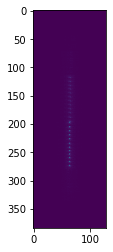

In [7]:
plt.imshow(np.abs(data.as_array()[:, 0, :]))
plt.show()

In [8]:
# Define the model
unet = UNet(dim=3, 
          n_ch_in=2, 
          n_ch_out=3, 
          n_enc_stages=3,
          n_convs_per_stage=2, 
          n_filters=16,
          kernel_size=3, 
          res_connection=False,
          bias=True)

print(unet)

UNet(
  (encoder): Encoder(
    (enc_blocks): ModuleList(
      (0): ConvBlock(
        (conv_block): Sequential(
          (0): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): LeakyReLU(negative_slope=0.01)
          (2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): LeakyReLU(negative_slope=0.01)
        )
      )
      (1): ConvBlock(
        (conv_block): Sequential(
          (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): LeakyReLU(negative_slope=0.01)
          (2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): LeakyReLU(negative_slope=0.01)
        )
      )
      (2): ConvBlock(
        (conv_block): Sequential(
          (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): LeakyReLU(negative_slope=0.01)
          (2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride

In [9]:
model = LearnedTVMapCNN(unet, T=1)
# print(tv)

# test = tv(data, model)

In [10]:
# Loss function
loss_func = torch.nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
# Test Data Loader
next(iter(train_loader))

Started reading acquisitions from /home/jovyan/data/input_data/y_21.h5
0%..10%..20%..30%..40%..50%..60%..70%..80%..90%..99%..
Finished reading acquisitions from /home/jovyan/data/input_data/y_21.h5


 tensor([[[[185., 172., 154.,  ..., 253., 248., 243.],
           [194., 197., 198.,  ..., 248., 248., 244.],
           [200., 192., 184.,  ..., 238., 239., 236.],
           ...,
           [161.,  89.,  72.,  ..., 241., 236., 255.],
           [ 85.,  63., 100.,  ..., 238., 237., 242.],
           [ 68., 101., 135.,  ..., 234., 241., 246.]],
 
          [[186., 171., 153.,  ..., 255., 252., 242.],
           [192., 196., 198.,  ..., 247., 249., 243.],
           [199., 193., 186.,  ..., 235., 236., 237.],
           ...,
           [158.,  87.,  83.,  ..., 240., 239., 252.],
           [ 84.,  67., 105.,  ..., 230., 241., 249.],
           [ 78., 111., 133.,  ..., 228., 242., 243.]],
 
          [[187., 173., 155.,  ..., 254., 249., 245.],
           [194., 198., 200.,  ..., 246., 249., 243.],
           [201., 196., 188.,  ..., 236., 238., 236.],
           ...,
           [154., 103., 101.,  ..., 239., 235., 255.],
           [ 84.,  66., 113.,  ..., 229., 239., 246.],
           

In [12]:
# Define training routine for one batch
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    for i, data in enumerate(train_loader):
        # Every data instance is an input + label pair
        inputs, labels, acq_model = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs, acq_model)

        # Compute the loss and its gradients
        loss = mse_loss(outputs, labels)
        # loss.backward()

        # Adjust learning weights
        # optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 100 == 99:
            last_loss = running_loss / 100 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [13]:
# TRAINING LOOP

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('/home/jovyan/runs/trainer_{}'.format(timestamp))
epoch_number = 0

for epoch in range(epochs):
    print('EPOCH {}:'.format(epoch_number + 1))

    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(valid_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    model_path = 'model_{}_{}'.format(timestamp, epoch_number)
    torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
Started reading acquisitions from /home/jovyan/data/input_data/y_416.h5
0%..10%..20%..30%..40%..50%..60%..70%..80%..90%..99%..
Finished reading acquisitions from /home/jovyan/data/input_data/y_416.h5
tensor([[[[ 86.5861-4.1268e+01j,  79.5478-3.4778e+01j,  72.3825-2.0836e+01j,
            ..., 117.6717-4.9221e+01j, 119.3277-5.0527e+01j,
           114.9820-4.7778e+01j],
          [ 74.1430-3.7120e+01j,  66.6747-2.7998e+01j,  59.2173-2.1580e+01j,
            ...,  88.1706-3.5841e+01j,  86.8039-4.2272e+01j,
            89.0438-4.5880e+01j],
          [ 65.3684-2.8667e+01j,  57.2854-1.9889e+01j,  55.5365-3.9477e+00j,
            ...,  70.6622-2.9285e+01j,  65.3867-3.5768e+01j,
            70.2722-4.4931e+01j],
          ...,
          [118.3663+2.8015e+00j, 118.0945+6.0440e-01j, 115.4954+2.7711e+00j,
            ..., 205.2309+4.4387e+00j, 198.8341+6.4547e-01j,
           196.1474+3.9151e+00j],
          [120.7018+1.1105e+00j, 117.5525+7.8169e-01j, 111.0901+1.1621e+01j,
           

NameError: name 'mse_loss' is not defined